<h1>Algorithmen in der Algebra, Woche 1</h1>

In [212]:
import unittest
import random
import time

In [213]:
#Input: (f,r), where:
#f is the function you want to test (between quotation marks),
#r is the list of inputs you want to test it on.
#Output: a list of times in seconds.
#Also displays a plot of this list.
from sage.misc.sage_timeit import sage_timeit
def my_timeit(f,r):
    for i in r:
        L=flatten([sage_timeit(f+'('+str(i)+')', globals(), preparse=True, number=1, repeat=1).series for i in r])
        list_plot(L).show()
        return L

<h2>Addition von nicht-negativen ganzen Zahlen</h2> 

In [214]:
b=10;

In [215]:
def strip_zeroes(z):
    zz=z[:] #Liste kopieren
    while len(zz)>0 and zz[0]==0:
        zz.pop(0)
    return zz

In [216]:
#Beispiel
strip_zeroes([0,0,1,2,0,4,0])

[1, 2, 0, 4, 0]

In [217]:
def addition(x,y):
    m = len(x)
    n = len(y)
    c = 0
    z = []
    for i in [0..max(m,n)]:
        if i < m:
            c = c + x[m-i-1]
        if i < n:
            c = c + y[n-i-1]
        z.insert(0,c%b)
        c = c//b
    z=strip_zeroes(z)
    return z

In [218]:
addition([8,4,3],[2,7,9])

[1, 1, 2, 2]

In [219]:
addition([3,8],[3,8,0])

[4, 1, 8]

<h2>Langsame Multiplikation von zwei Zahlen</h2>

In [220]:
def slow_times(x,y):
    z=[]
    m=len(x)
    for i in range(m):
        for j in range(x[m-i-1]):
            z=addition(z,y+(i*[0])) #Extra Nullen, da wir mit b^i multiplizieren müssen.
    z=strip_zeroes(z)
    return z

In [221]:
slow_times([2,1],[3,8])

[7, 9, 8]

In [222]:
def slow_times_test(n): #berechnet das Produkt von zwei Zahlen der Länge n.
    return slow_times([randint(0,9) for i in range(n)],[randint(0,9) for i in range(n)])

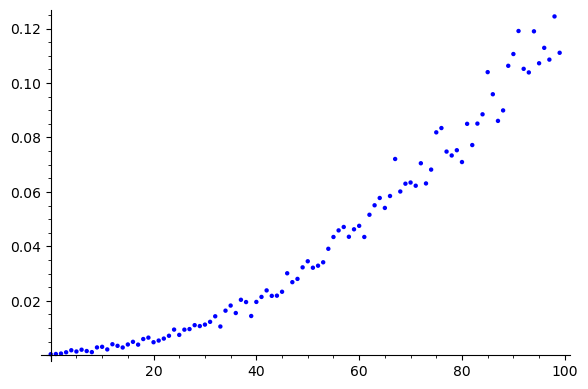

In [223]:
my_timeit('slow_times_test',[1..100]);

Man sieht das quadratische Verhalten.

In [224]:
#Liste zu Zahl. Kannst du als "black box" verwenden.
def liste_zu_zahl(numList):
    s = ''.join([str(i) for i in numList]) #Example what "join" does: '.'.join(['ab', 'pq', 'rs']) -> 'ab.pq.rs'
    return int(s)

In [225]:
#Beispiel
liste_zu_zahl([5,3,1])

531

In [226]:
def digits(x):
    return strip_zeroes([int(c) for c in str(x)])

In [228]:
class TestDigits(unittest.TestCase):

    def test_splits_into_digits(self):
        self.assertEqual(digits(123456), [1, 2, 3, 4, 5, 6])
        
    def test_strips_leading_zeroes(self):
        self.assertEqual(digits(0), [])
        
result = unittest.main(argv=[''], exit = False)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.533s

OK


In [230]:
def usual_times_test(n): #berechnet das Produkt von zwei Zahlen der Länge n.
    return liste_zu_zahl([randint(0,9) for i in range(n)])*liste_zu_zahl([randint(0,9) for i in range(n)])

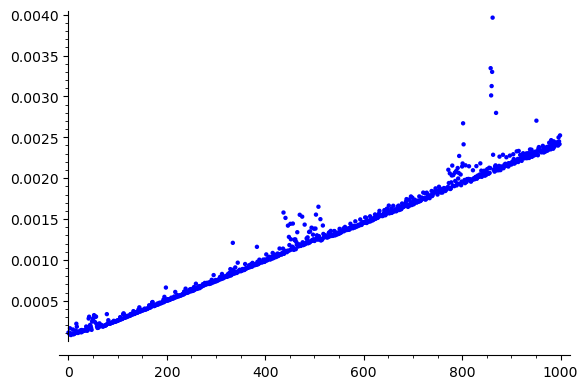

In [231]:
my_timeit('usual_times_test',[1..1000]);

Nicht nur ist die eingebaute Sage-Funktion Times viel schneller als SlowTimes; auch scheint das Verhalten gar nicht quadratisch.

<h2>Karatsuba</h2>

Implementieren Sie eine Funktion Subtraktion, ähnlich wie Addition, wo die Voraussetzung ist, dass die von x dargestellte Zahl groesser ist als die von y dargestellte Zahl (so dass keine neuen Symbole für negative Zahlen benötigt werden).

In [232]:
def subtract(x, y):
    m = len(x)
    n = len(y)
    
    c = 0
    z = []
    # Subtracting two values will certainly not cause the number of digits
    # to increase, simplifying this compared to addition.
    for i in [1..max(m,n)]:
        if i <= m:
            c = c + x[-i]
        if i <= n:
            c = c - y[-i]
        z.insert(0, c % b)
        c = c // b
        
    z = strip_zeroes(z)
    
    # x was less than y, so was an invalid input tuple
    if c < 0:
        raise ValueError("x may not be smaller than y")
    
    return z

In [233]:
class TestSubtract(unittest.TestCase):
    def test_valid_subtract(self):
        self.assertEqual(subtract([1, 2, 3], [4, 5]), [7, 8])
        self.assertEqual(subtract([4, 2, 7, 7], [2, 8, 9, 4]), [1, 3, 8, 3])
        self.assertEqual(subtract([4, 2], [4, 2]), [])

        # Let's add some non-determinism to tests. What could go wrong. (:
        for i in range(10000):
            x = random.randint(0, 10000)
            y = random.randint(0, x)
            z = x - y
            self.assertEqual(subtract(digits(x), digits(y)), digits(z))
        
    def test_invalid_subtract(self):
        # First argument must be larger than second
        with self.assertRaises(ValueError):
            subtract([4, 5], [1, 2, 3])
        
result = unittest.main(argv=[''], exit = False)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.522s

OK


Implementieren Sie den Algorithmus von Karatsuba, indem Sie eine Funktion schreiben, die bei Input zwei Listen von Zahlen in [0,...,b-1] die Liste zurückgibt, die das Produkt darstellt. Sie sollten dabei die Funktion addition und ihre eigene Funktion subtraktion benutzen. Sobald die Zahlen zu klein sind (vielleicht Länge < 6, experimentieren Sie!), sollen Sie statt Rekursion zu benutzen die Funktion slow_times benutzen. Zeigen Sie mit my_timeit das Verhalten Ihrer Funktion bis Zahlen der Grösse 100 oder 200. Hoffentlich ist ihre Funktion schneller als slow_times!

In [234]:
def karatsuba_mult(x, y, slow_multiplication_threshold=40):
    # Pad inputs to even length
    if len(x) % 2 != 0:
        x.insert(0, 0)
    if len(y) % 2 != 0:
        y.insert(0, 0)
        
    # Pad both inputs to same length.
    if len(x) < len(y):
        x = [0] * (len(y) - len(x)) + x
    if len(y) < len(x):
        y = [0] * (len(x) - len(y)) + y
        
    n = len(x)
    n_half = int(n / 2) # Sage will turn n/2 into a rational otherwise
    
    # print(f"Padded input lengths: {n}")
    
    # Below a certain amount of digits, fall back to grade-school multiplication.
    # Default was experimentally chosen to fit my hardware.
    if n <= slow_multiplication_threshold:
        mult = lambda x, y : slow_times(x, y)
    else:
        mult = lambda x, y: karatsuba_mult(x, y, slow_multiplication_threshold)
        
    x_high, x_low = x[: n_half], x[n_half :]
    y_high, y_low = y[: n_half], y[n_half :]
    
    # x_hi * y_hi
    x_high_y_high = mult(x_high, y_high)
    
    # x_lo * y_lo
    x_low_y_low = mult(x_low, y_low)
    
    # x_hi * y_lo + x_lo * y_hi
    x_y_highlow_sum = mult(
            addition(x_high, x_low),
            addition(y_high, y_low),
    )
    x_y_highlow_sum = subtract(
        x_y_highlow_sum,
        x_high_y_high,
    )
    x_y_highlow_sum = subtract(
        x_y_highlow_sum,
        x_low_y_low,
    )
     
    # The result now is `(x_hi y_hi) * B^n + (x_hi y_low + x_low y_hi) * B^(n/2) + (x_low y_low) * B^0`
    # Where `B` is the base (in our case 10), and `n` the `max { length(x), length(y) }` respectively
    # We will achieve the multiplication with powers of the base by shifting the digits (right-padding with zero), 
    # and then add the results together.
    x_high_y_high = x_high_y_high + [0] * n
    x_y_highlow_sum = x_y_highlow_sum + [0] * n_half
    
    product = addition(
        x_high_y_high,
        x_y_highlow_sum,
    )
    product = addition(
        product,
        x_low_y_low,
    )
    
    return product

In [235]:
class TestKaratsubaMult(unittest.TestCase):
    def test_valid_multiplication(self):
        self.assertEqual(
            karatsuba_mult(
                digits(1234),
                digits(5678),
            ),
            digits(7006652),
        )
        
        self.assertEqual(
            karatsuba_mult(
                digits(139012),
                digits(935),
            ),
            digits(129976220),
        )
        
        # Let's add some non-determinism to tests. What could go wrong. (:
        for i in range(100):
            x = random.randint(0, 100000000)
            y = random.randint(0, 100000000)
            z = x * y
            self.assertEqual(karatsuba_mult(digits(x), digits(y)), digits(z))
 
result = unittest.main(argv=[''], exit = False)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.531s

OK


In [245]:
def karatsuba_times_test(n):
    x = random.randint(10**(n-1), 10**n)
    y = random.randint(10**(n-1), 10**n) 
    print(f"{x} * {y} ({n} digits)")
    return karatsuba_mult(digits(x), digits(y), 40)

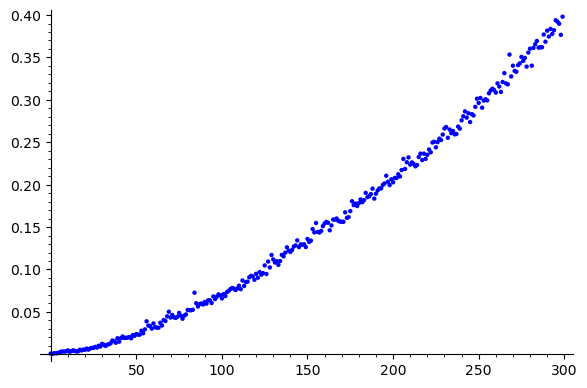

In [251]:
karatsuba_timings = my_timeit('karatsuba_times_test',[1..300]);

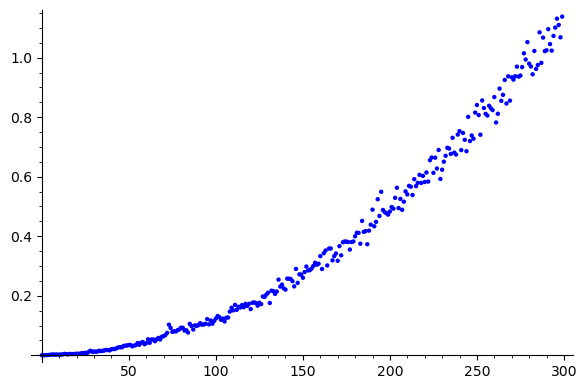

In [237]:
my_timeit('slow_times_test',[1..300]);

While the custom implementation of Karatsuba is - for sufficiently large numbers - noticeably faster (e.g. 0.2s vs 0.5s for a 200 digit number), there is still a clear super-linear growth. Further the absolute running times are rather poor still.

In [269]:
print(len(karatsuba_timings))
data = [(i+1, karatsuba_timings[i]) for i in range(len(karatsuba_timings))]

var('x, a, b, c')
model(x) = a*x^(b) + c
fit = find_fit(data, model)
fit

300


[a == (4.920442496241363e-05),
 b == 1.574118447347578,
 c == 0.0007705676719686398]

However, fitting a model $f(x) = a x^b + c$ (using scipy's least-squares optimizer) to the measurements results in an exponent of $\approx 1.57$, which is very close to the expected $1.58$. As such the general structure of the implementation seems to be correct.